# Analiza podataka train dataset-a

U ovoj bilježnici nalaze se postupci analize i vizualizacije podataka train dataset-a.

Prvo počinjemo uvozom potrebnih biblioteka.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from scipy.stats import shapiro 
from scipy.stats import lognorm
from scipy.stats import kstest,norm
from scipy.stats import lognorm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings("ignore")

Zatim pronalazimo lokaciju i učitavamo datoteku s podatcima.

In [3]:
path = Path.cwd().parent
filePath = str(path) + "/data_cleanup/second_dataset/train_data_cleaned.parquet"
df = pd.read_parquet(filePath)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14824 entries, 0 to 31633
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   reservation_id      14824 non-null  int64         
 1   stay_date           14824 non-null  datetime64[ns]
 2   guest_id            14824 non-null  int64         
 3   guest_country_id    14824 non-null  object        
 4   reservation_status  14824 non-null  object        
 5   reservation_date    14824 non-null  datetime64[ns]
 6   date_from           14824 non-null  datetime64[ns]
 7   date_to             14824 non-null  datetime64[ns]
 8   resort_id           14824 non-null  int64         
 9   cancel_date         2764 non-null   object        
 10  room_cnt            14824 non-null  int64         
 11  adult_cnt           14824 non-null  int64         
 12  children_cnt        14824 non-null  int64         
 13  price               12845 non-null  float64       


Podatke "stay_nights" i "price_per_night" smo dodali pri inicijalnom procesiranju podataka radi lakših daljnih razmatranja.

## Generalni pregled podataka

### Status rezervacije

In [4]:
df["reservation_status"].unique()

array(['Checked-out', 'Cancelled', 'No-show'], dtype=object)

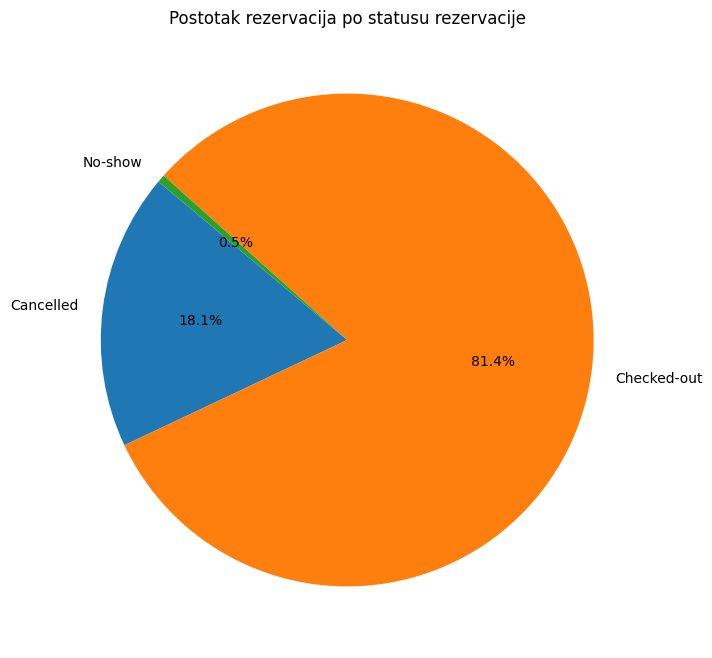

In [5]:
freq_by_status = df["reservation_status"].value_counts().sort_index()

plt.figure(figsize=(10, 8))
plt.pie(freq_by_status, labels=freq_by_status.index, autopct = "%1.1f%%", startangle = 140)
plt.title("Postotak rezervacija po statusu rezervacije")
plt.show()

Graf je očekivan i nemamo razlog misliti da ima ikakvih problema sa statusima rezervacije.

### Zemlja gosta

In [6]:
df["guest_country_id"].unique()

array(['HR', 'GB', 'AUT', 'SLO', 'I', 'BR', 'F', 'AUS', 'NL', 'BEL', 'CS',
       'D', 'SGP', 'CDN', 'S', 'CH', 'SF', 'MNE', 'H', 'USA', 'IL', 'GR',
       'BIH', 'IRL', 'UKR', 'DK', 'RO', 'RUS', 'SRB', 'N', 'ROK', 'SMR',
       'BG', 'J', 'E', 'MAC', 'LUX', 'BEN', 'CHN', 'MLT', 'SL', 'P',
       'VEN', 'TR', 'PL', 'NGA', 'NZ', 'ZA', 'ARE', 'LIT', 'IS', 'ABW',
       'RA', 'YEM', 'PHL', 'ALB', 'EST', 'CYP', 'LET', 'L', 'ET', 'COL',
       'RCH', 'TAI', 'THA'], dtype=object)

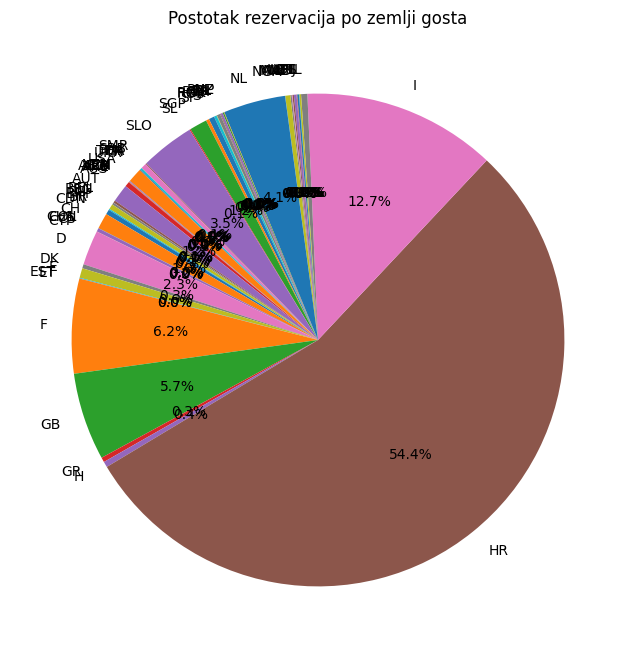

In [7]:
freq_by_country = df["guest_country_id"].value_counts().sort_index()

plt.figure(figsize=(10, 8))
plt.pie(freq_by_country, labels = freq_by_country.index, autopct='%1.1f%%', startangle=140)
plt.title('Postotak rezervacija po zemlji gosta')
plt.show()

Ovaj graf također ne indicira na neki daljni problem s preostalim podatcima.

### Hotel ID

In [8]:
df["resort_id"].unique()

array([1])

Vidimo da su podatci od samo jednog hotela/resorta.

In [9]:
del df["resort_id"]

### Kategorija sobe

In [10]:
df["room_category_id"].unique()

array([ 3,  4,  5,  6,  7,  2, 11,  1])

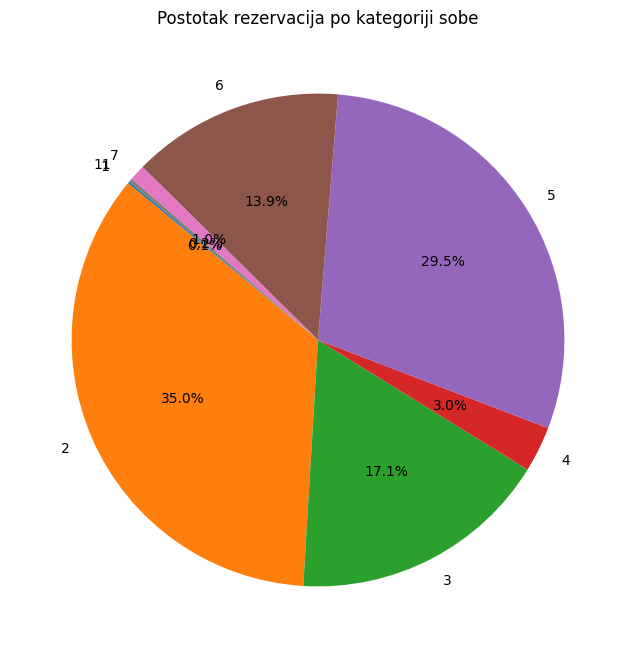

In [11]:
freq_by_room = df["room_category_id"].value_counts().sort_index()

plt.figure(figsize=(10, 8))
plt.pie(freq_by_room, labels = freq_by_room.index, autopct='%1.1f%%', startangle=140)
plt.title('Postotak rezervacija po kategoriji sobe')
plt.show()

### Broj djece 

In [12]:
df["children_cnt"].unique()

array([0, 1])

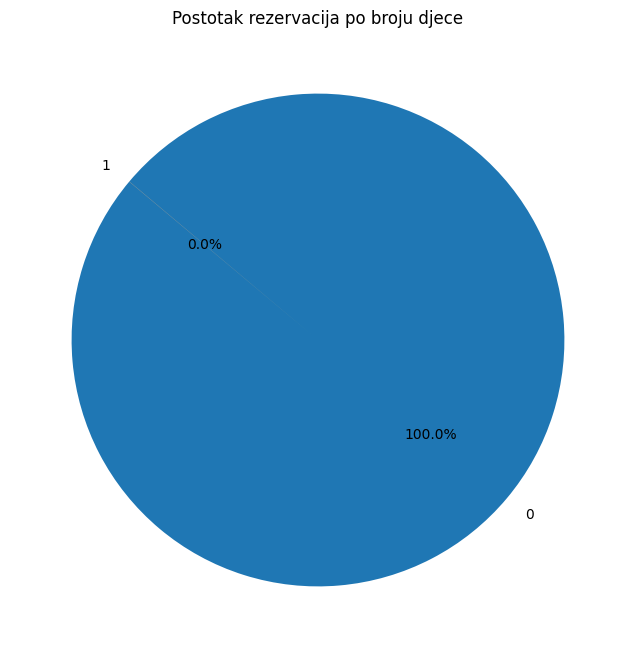

In [13]:
freq_by_child_count = df["children_cnt"].value_counts().sort_index()

plt.figure(figsize=(10, 8))
plt.pie(freq_by_child_count, labels = freq_by_child_count.index, autopct='%1.1f%%', startangle=140)
plt.title('Postotak rezervacija po broju djece')
plt.show()

Broj djece je neočekivan i moguća anomalija ili greška pri prikupljanju podataka. Dalje ćemo zanemariti broj djece.

### Broj odraslih gostiju

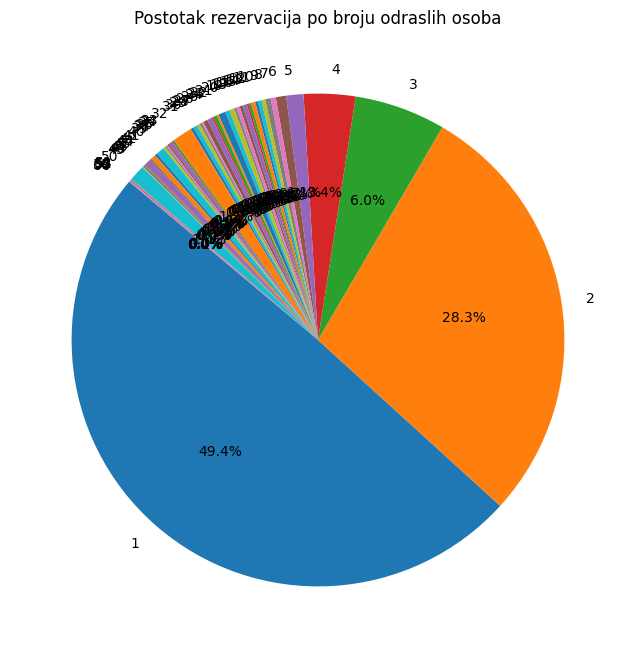

In [14]:
freq_by_adult_count = df['adult_cnt'].value_counts().sort_index()

plt.figure(figsize=(10, 8))
plt.pie(freq_by_adult_count, labels = freq_by_adult_count.index, autopct='%1.1f%%', startangle=140)
plt.title('Postotak rezervacija po broju odraslih osoba')
plt.show()

Graf je očekivan i ne upućuje na moguće probleme ili greške.

### Broj noćenja

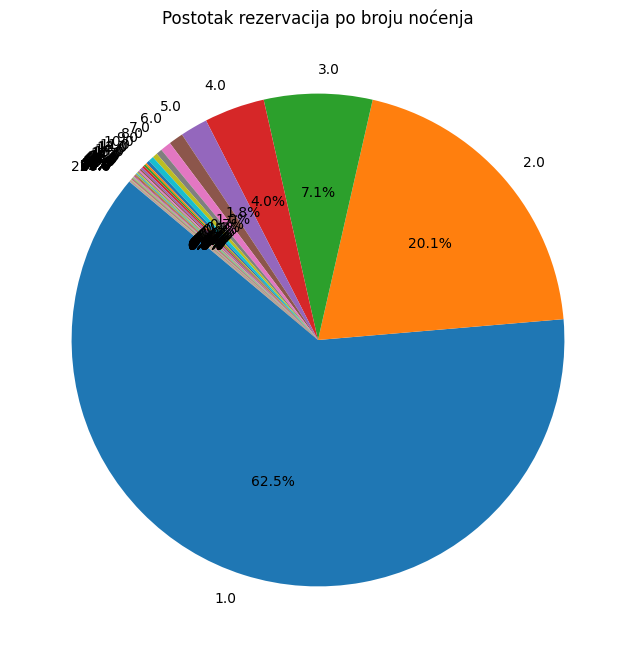

In [15]:
freq_by_stay = df["stay_nights"].value_counts().sort_index()

plt.figure(figsize=(10, 8))
plt.pie(freq_by_stay, labels = freq_by_stay.index, autopct = "%1.1f%%", startangle = 140)
plt.title("Postotak rezervacija po broju noćenja")
plt.show()

Graf broja noćenja je također očekivan i razuman.

## Analiza podataka gostiju s provedenom rezervacijom

Promatramo podatke kojima je status rezervacije "Checked-out".

In [16]:
init_df = df #spremanje inicijalnih podataka
df = df[df["reservation_status"] == "Checked-out"]
init_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14824 entries, 0 to 31633
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   reservation_id      14824 non-null  int64         
 1   stay_date           14824 non-null  datetime64[ns]
 2   guest_id            14824 non-null  int64         
 3   guest_country_id    14824 non-null  object        
 4   reservation_status  14824 non-null  object        
 5   reservation_date    14824 non-null  datetime64[ns]
 6   date_from           14824 non-null  datetime64[ns]
 7   date_to             14824 non-null  datetime64[ns]
 8   cancel_date         2764 non-null   object        
 9   room_cnt            14824 non-null  int64         
 10  adult_cnt           14824 non-null  int64         
 11  children_cnt        14824 non-null  int64         
 12  price               12845 non-null  float64       
 13  price_tax           12845 non-null  float64       


In [17]:
df.describe()

,reservation_id,stay_date,guest_id,reservation_date,date_from,date_to,room_cnt,adult_cnt,children_cnt,price,...,total_price_tax,total_price,food_price,food_price_tax,other_price,other_price_tax,room_category_id,sales_channel_id,stay_nights,price_per_night
count,12060.000000,12060,12060.000000,12060,12060,12060,12060.000000,12060.000000,12060.000000,11948.000000,...,12060.000000,12060.000000,11948.000000,11948.000000,11948.000000,11948.000000,12060.000000,12060.000000,12060.000000,11948.000000
mean,82803.398259,2008-12-26 07:50:48.358208768,73882.089801,2008-12-14 10:32:14.328358400,2008-12-26 07:50:48.358208768,2008-12-28 09:52:07.164178944,1.943781,2.704478,0.000083,10228.792617,...,1258.195197,13115.971815,1119.747842,111.952635,1879.167835,134.327725,3.674129,5.194279,2.084245,7337.076914
min,68240.000000,2007-12-13 00:00:00,104.000000,2007-05-23 00:00:00,2007-12-13 00:00:00,2007-12-15 00:00:00,1.000000,1.000000,0.000000,18.180000,...,0.000000,33.270000,9.090000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,3.030000
25%,78596.500000,2008-07-03 00:00:00,29370.000000,2008-06-17 00:00:00,2008-07-03 00:00:00,2008-07-04 00:00:00,1.000000,1.000000,0.000000,946.360000,...,103.190000,1092.205000,85.450000,8.550000,21.000000,0.000000,2.000000,3.000000,1.000000,816.360000
50%,82914.500000,2008-12-13 00:00:00,81445.000000,2008-12-03 00:00:00,2008-12-13 00:00:00,2008-12-17 00:00:00,1.000000,1.000000,0.000000,4401.608000,...,472.821000,4825.300000,311.929000,31.171000,102.200000,0.000000,3.000000,3.000000,1.000000,2775.788500
75%,87023.250000,2009-06-25 06:00:00,110818.750000,2009-06-13 00:00:00,2009-06-25 06:00:00,2009-06-28 00:00:00,1.000000,2.000000,0.000000,10185.033000,...,1164.350000,12397.863750,935.787000,93.586000,751.900000,13.090000,5.000000,10.000000,2.000000,6679.646000
max,91366.000000,2009-12-31 00:00:00,149866.000000,2009-12-31 00:00:00,2009-12-31 00:00:00,2010-01-16 00:00:00,50.000000,56.000000,1.000000,291956.930000,...,42805.375000,370963.954000,27447.051000,2745.749000,70290.021000,11374.203000,11.000000,18.000000,226.000000,248166.639000
std,4919.873141,NaN,42172.540901,NaN,NaN,NaN,3.403898,5.552953,0.009106,19390.530858,...,2578.609457,26729.797948,2627.978353,262.858567,6082.587726,521.672929,1.621220,3.481626,3.929286,15735.011024


Prvo nas zanima dnevnih broj ljudi u hotelu. Podatke odvajamo po danima i goste gledamo kao broj odraslih + broj djece.

In [18]:
df["guest_count"] = df["adult_cnt"] + df["children_cnt"]
occupancy = df[(df["cancel_date"].isna())]

dates = []
for index, row in occupancy.iterrows():
    delta = (row["date_to"] - row["date_from"]).days
    for i in range(delta):
        dates.append((row["date_from"] + pd.Timedelta(days=i), row["guest_count"]))

# Pretvaranje u DataFrame
dates_df = pd.DataFrame(dates, columns=["date", "guest_count"])

# Grupiranje po datumu i sumiranje broja gostiju
occupancy = dates_df.groupby("date")["guest_count"].sum().reset_index()
occupancy.index = occupancy["date"]
del occupancy["date"]
occupancy.index = pd.to_datetime(occupancy.index)


Nakon odvajanja podataka po danima i prebrojavanja ukupnog broja gostiju na grafu promatramo distibuciju tih podataka.

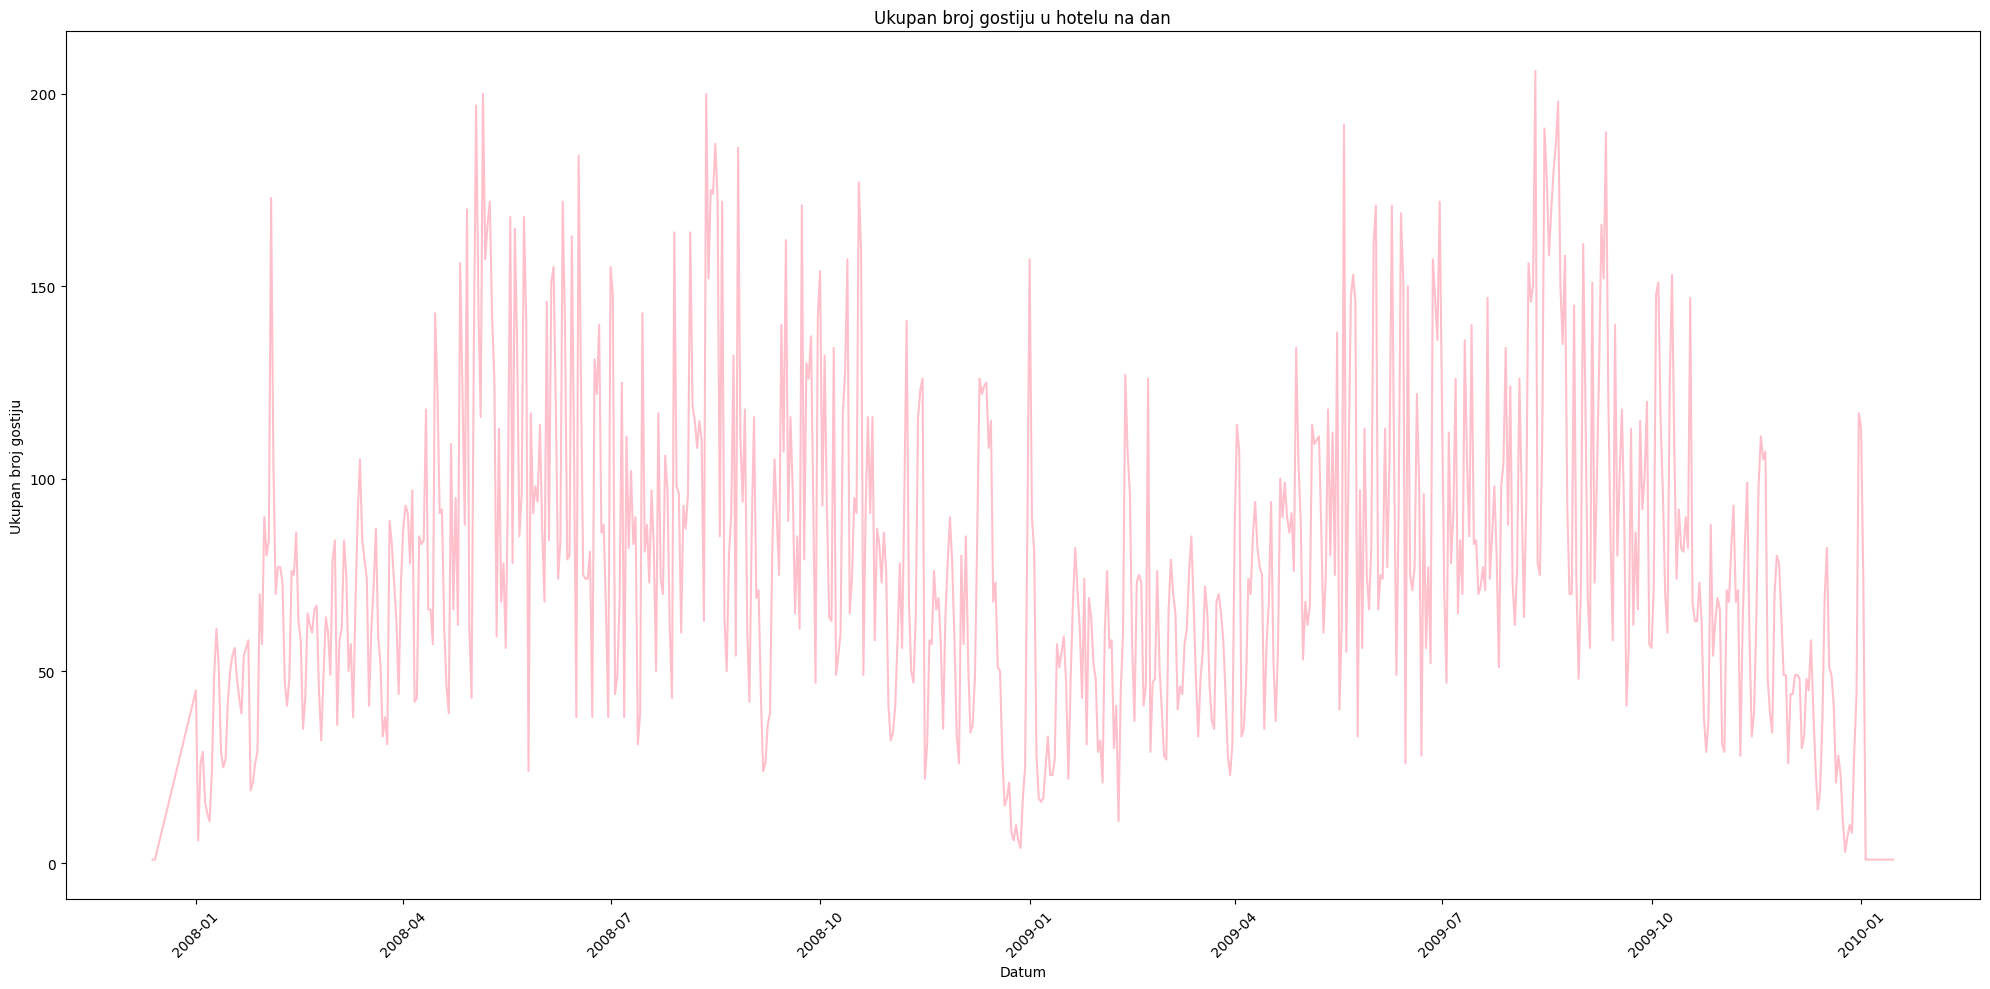

In [19]:
plt.figure(figsize=(20, 10))  
plt.plot(occupancy.index, occupancy["guest_count"], color="pink")
plt.title("Ukupan broj gostiju u hotelu na dan")
plt.xlabel("Datum")
plt.ylabel("Ukupan broj gostiju")
plt.xticks(rotation = 45) 
plt.tight_layout()  
plt.show()

Sad imamo graf popunjenosti hotela. Iz grafa vidimo nagle padove u prvom mjesecu koje ćemo kasnije istražiti te također sličnost podataka s istim mjesecom godinu ranije/kasnije. Sličnost je očekivana i razumna s mogućnosti gledanja sezonalnosti na 12 mjeseci za veću podjeljenost ili kvartalnu sezonalnost po godišnjim dobima ili školskim/akademskim/poslovnim razdobljima. Također iz grafa vidimo veliku volatilnost što nam upućuje da jednostavniji modeli neće moći dati optimalnu točkastu procjenu nego je potrebno odrediti zadovoljavajući interval pouzdanosti i dati predviđanje u tim granicama. 

Dalje gledamo kretanje broja rezervacija.


In [20]:
reservation_count = df["reservation_date"].value_counts().reset_index()
reservation_count.index = reservation_count["reservation_date"]
del reservation_count["reservation_date"]
reservation_count.sort_index(inplace = True)
#reservation_count.head()


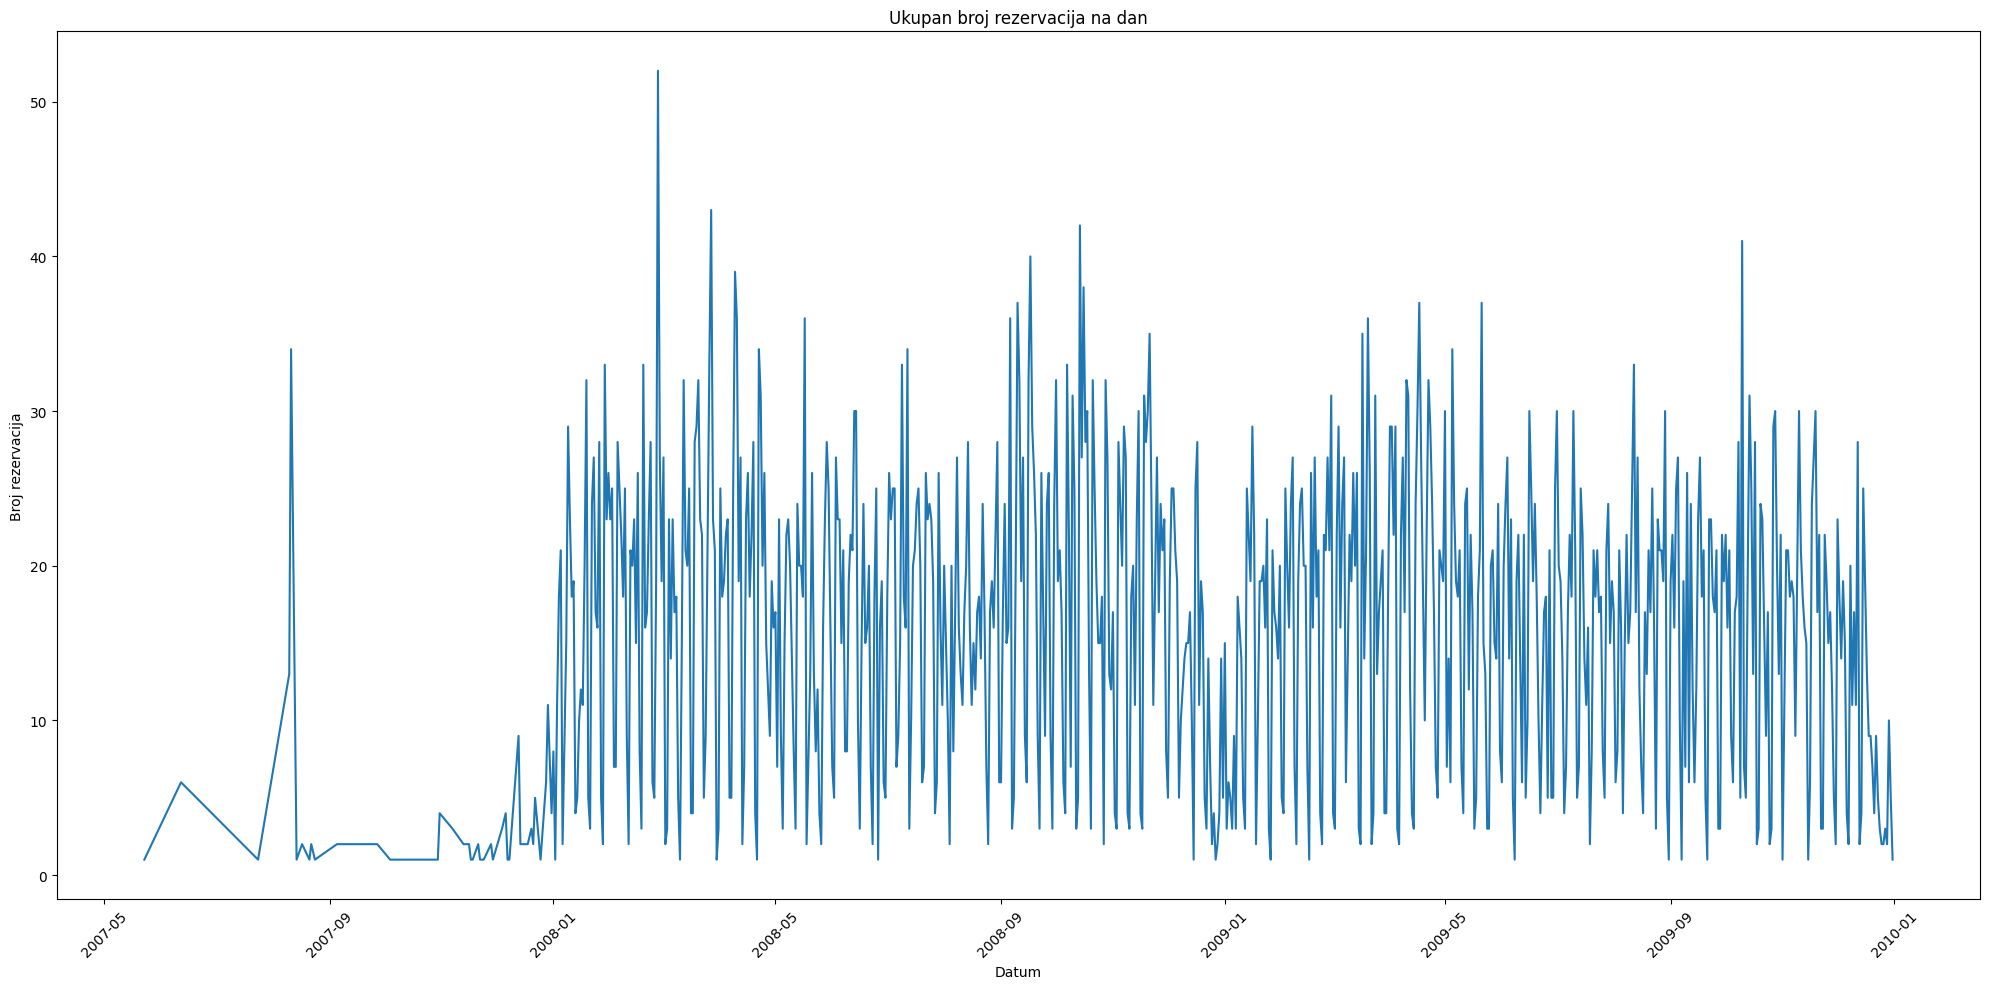

In [21]:
plt.figure(figsize=(20, 10))  
plt.plot(reservation_count.index, reservation_count["count"])
plt.title("Ukupan broj rezervacija na dan")
plt.xlabel("Datum")
plt.ylabel("Broj rezervacija")
plt.xticks(rotation = 45) 
plt.tight_layout()  
plt.show()

Dalje gledamo dnevni broj dolazaka.

In [22]:
arrival = df[(df["cancel_date"].isna())]
arrival_count = arrival["date_from"].value_counts().reset_index()
arrival_count.index = arrival_count["date_from"]
del arrival_count["date_from"]
arrival_count.sort_index(inplace = True)
#arrival_count.head()

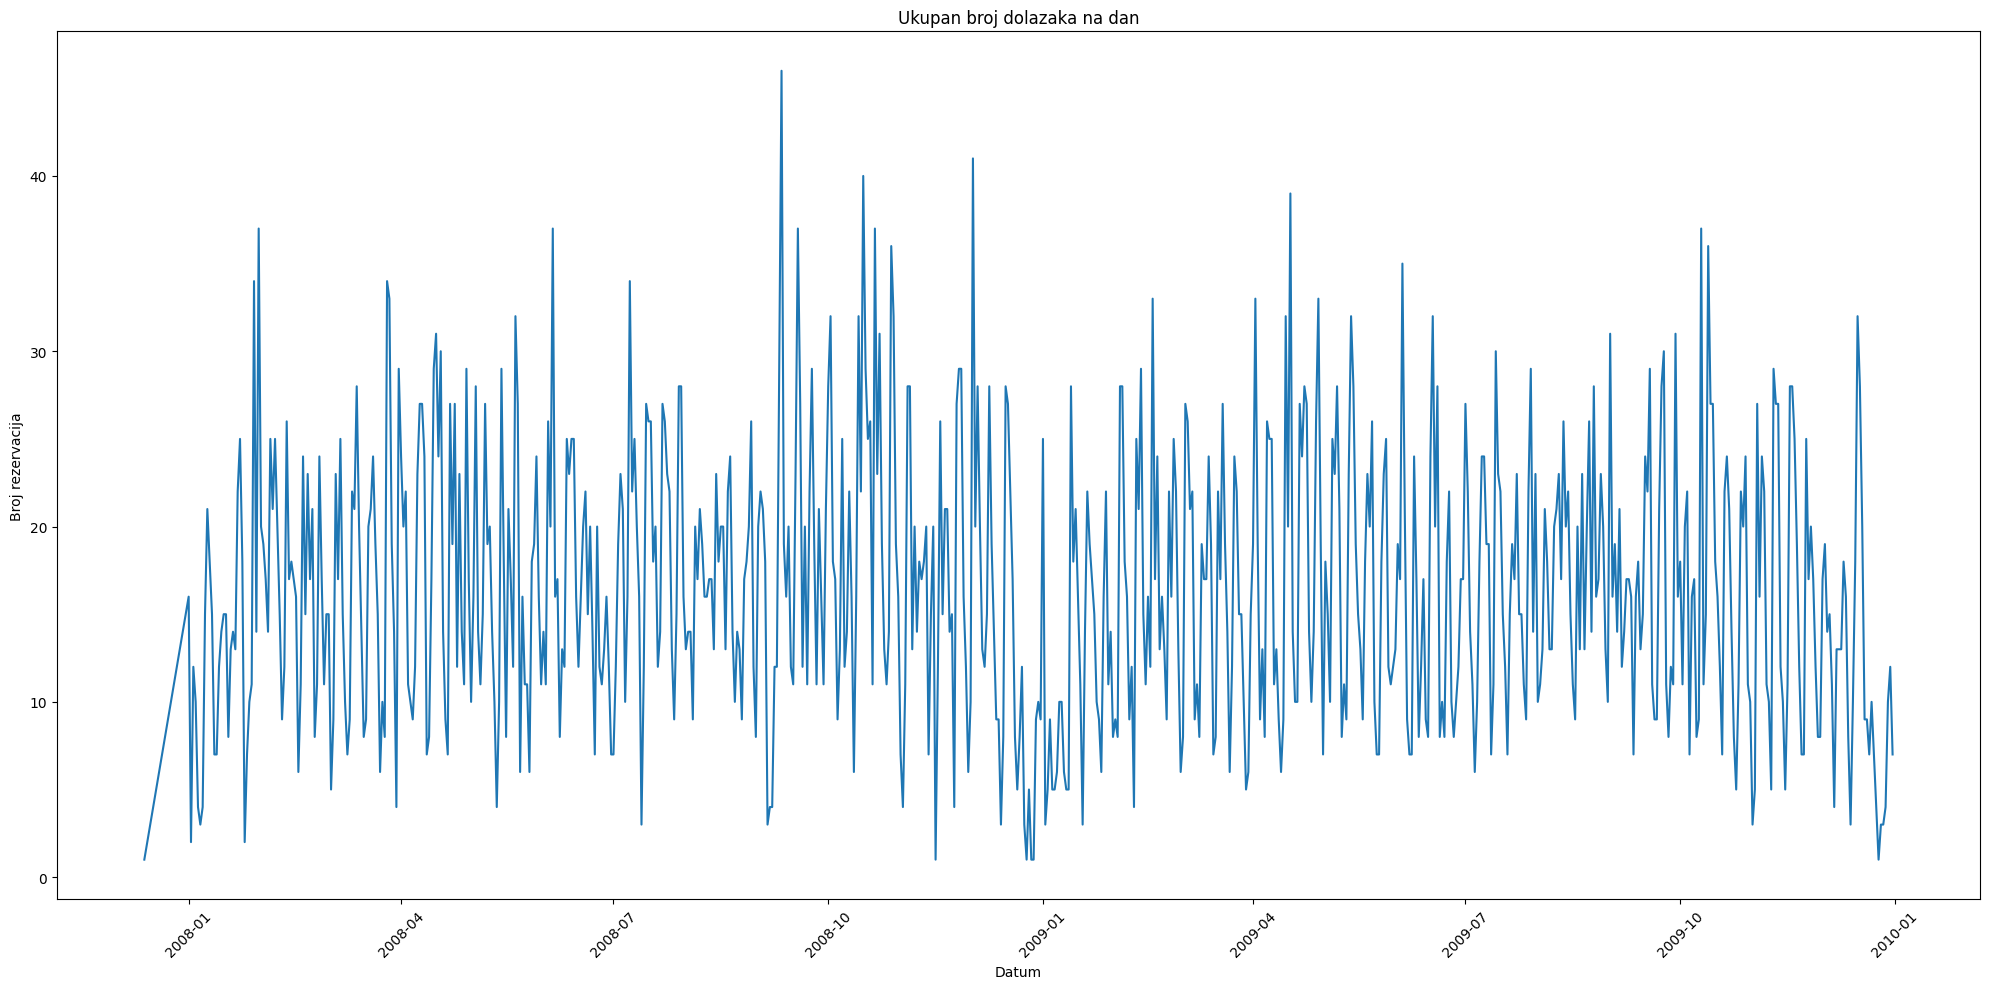

In [23]:
plt.figure(figsize=(20, 10))  
plt.plot(arrival_count.index, arrival_count["count"])
plt.title("Ukupan broj dolazaka na dan")
plt.xlabel("Datum")
plt.ylabel("Broj rezervacija")
plt.xticks(rotation = 45) 
plt.tight_layout()  
plt.show()

In [24]:
room_occupancy = df[(df["cancel_date"].isna())]

dates = []
for index, row in room_occupancy.iterrows():
    delta = (row["date_to"] - row["date_from"]).days
    for i in range(delta):
        dates.append((row["date_from"] + pd.Timedelta(days=i), row["room_cnt"]))

# Pretvaranje u DataFrame
room_dates_df = pd.DataFrame(dates, columns=["date", "room_cnt"])

# Grupiranje po datumu i sumiranje broja gostiju
room_occupancy = room_dates_df.groupby("date")["room_cnt"].sum().reset_index()
room_occupancy.index = room_occupancy["date"]
del room_occupancy["date"]
#room_occupancy.head()

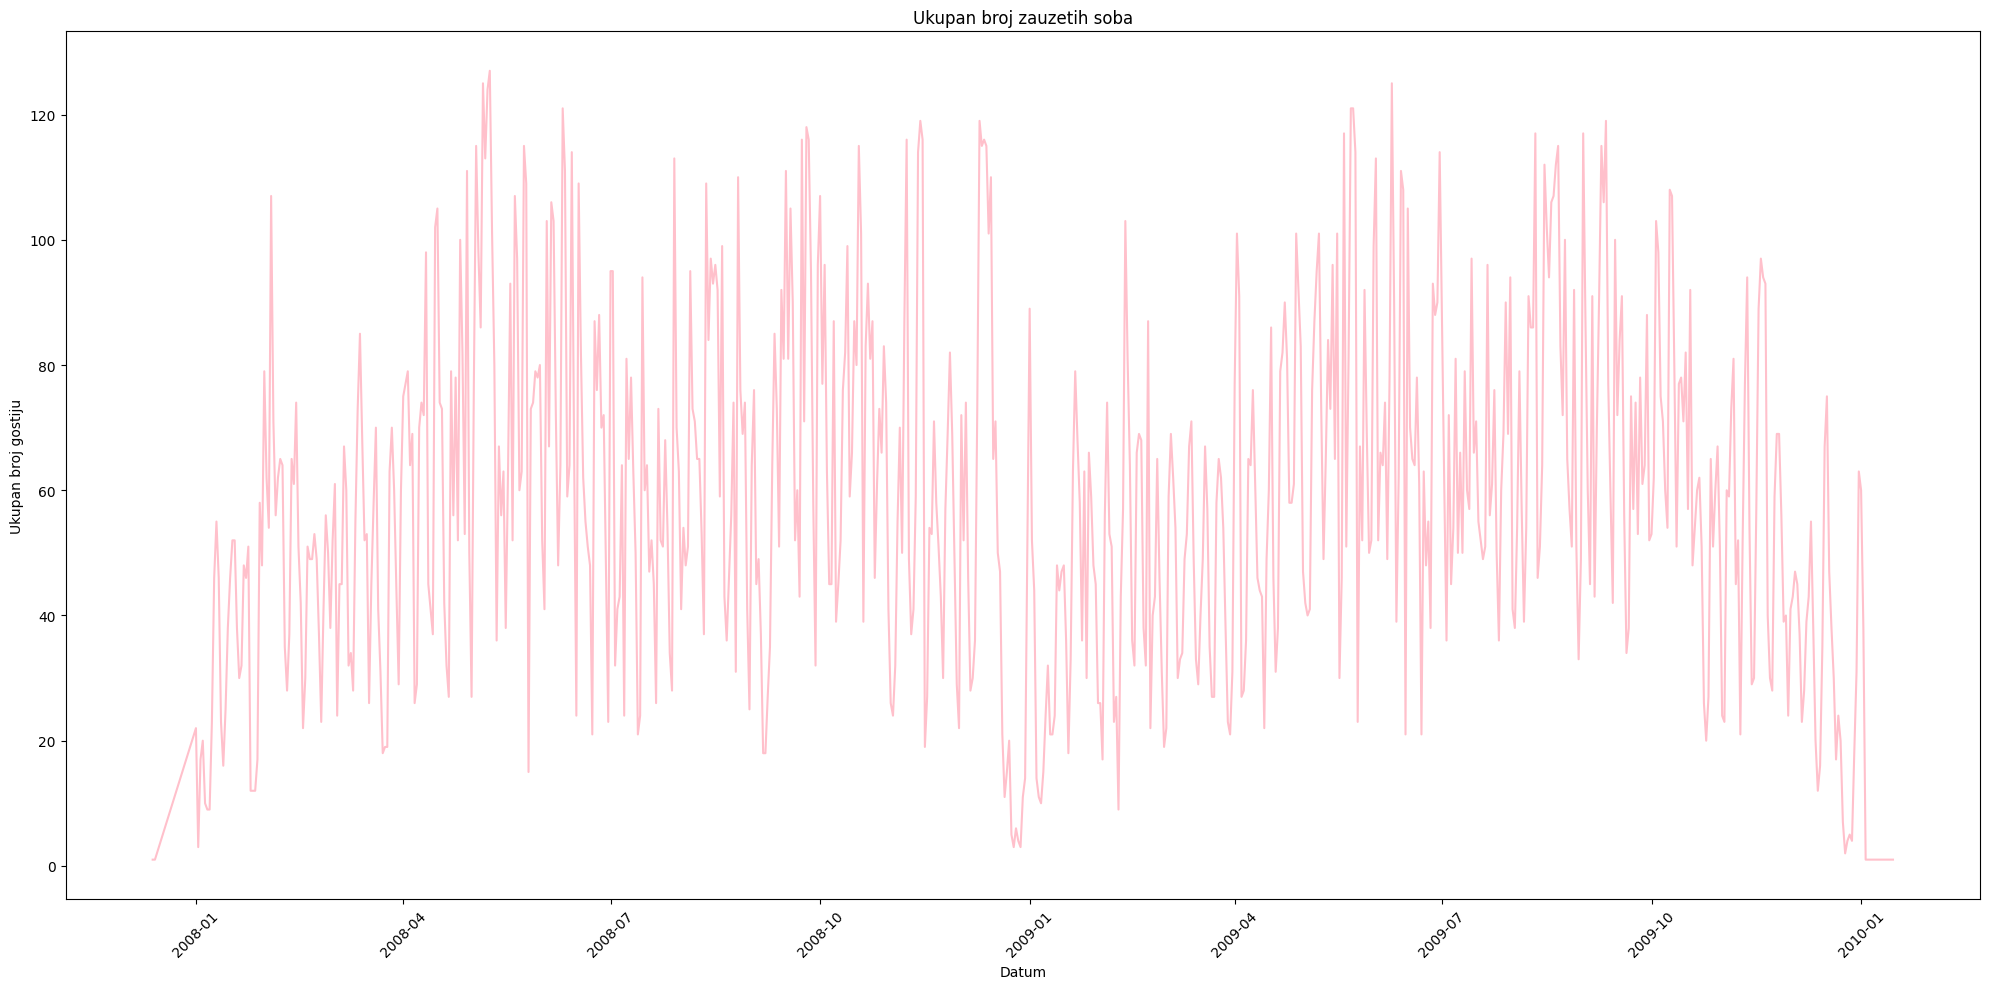

In [25]:
plt.figure(figsize=(20, 10))  
plt.plot(room_occupancy.index, room_occupancy["room_cnt"], color="pink")
plt.title("Ukupan broj zauzetih soba")
plt.xlabel("Datum")
plt.ylabel("Ukupan broj gostiju")
plt.xticks(rotation = 45) 
plt.tight_layout()  
plt.show()

### Distribucija cijene noćenja

Budući da smo ranije vidjeli da postoje rezervacije s povećim brojem gostiju koji vjerojatno predstavljaju agencije i sl. ćemo kreirati novi podataka "nightly_price_per_person" jer bi "price_per_night" lagano mogao imati ogroman podatak koji bi jako utjecao na prosjek.

In [26]:
init_df["nightly_price_per_guest"] = init_df["price_per_night"] / init_df["adult_cnt"]
init_df.info()
df["nightly_price_per_guest"] = df["price_per_night"] / df["adult_cnt"]

<class 'pandas.core.frame.DataFrame'>
Index: 14824 entries, 0 to 31633
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   reservation_id           14824 non-null  int64         
 1   stay_date                14824 non-null  datetime64[ns]
 2   guest_id                 14824 non-null  int64         
 3   guest_country_id         14824 non-null  object        
 4   reservation_status       14824 non-null  object        
 5   reservation_date         14824 non-null  datetime64[ns]
 6   date_from                14824 non-null  datetime64[ns]
 7   date_to                  14824 non-null  datetime64[ns]
 8   cancel_date              2764 non-null   object        
 9   room_cnt                 14824 non-null  int64         
 10  adult_cnt                14824 non-null  int64         
 11  children_cnt             14824 non-null  int64         
 12  price                    12845 non-nu

Zatim ćemo maknuti podatke kojima je cijena noćenja ispod 150. Podatke trenutno nema smisla promatrati, ali također ne mora značiti da su ti podatci anomalije pa ih nećemo kompletno maknuti. Također ćemo maknuti podatke koji imaju preveliku cijenu.

In [27]:
prices_df = df[df["price_per_night"] > 150]
prices_df = prices_df[prices_df["nightly_price_per_guest"] < 15000]
prices_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11175 entries, 0 to 31633
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   reservation_id           11175 non-null  int64         
 1   stay_date                11175 non-null  datetime64[ns]
 2   guest_id                 11175 non-null  int64         
 3   guest_country_id         11175 non-null  object        
 4   reservation_status       11175 non-null  object        
 5   reservation_date         11175 non-null  datetime64[ns]
 6   date_from                11175 non-null  datetime64[ns]
 7   date_to                  11175 non-null  datetime64[ns]
 8   cancel_date              0 non-null      object        
 9   room_cnt                 11175 non-null  int64         
 10  adult_cnt                11175 non-null  int64         
 11  children_cnt             11175 non-null  int64         
 12  price                    11175 non-nu

In [28]:
price_bins = np.arange(100, prices_df["nightly_price_per_guest"].max(), 30)
price_ranges = pd.cut(prices_df["nightly_price_per_guest"], bins = price_bins)
price_counts = price_ranges.value_counts().sort_index()
price_midpoints = price_bins[:-1] + np.diff(price_bins) / 2
price_counts_df = pd.DataFrame({"price": price_midpoints, "count": price_counts.values})

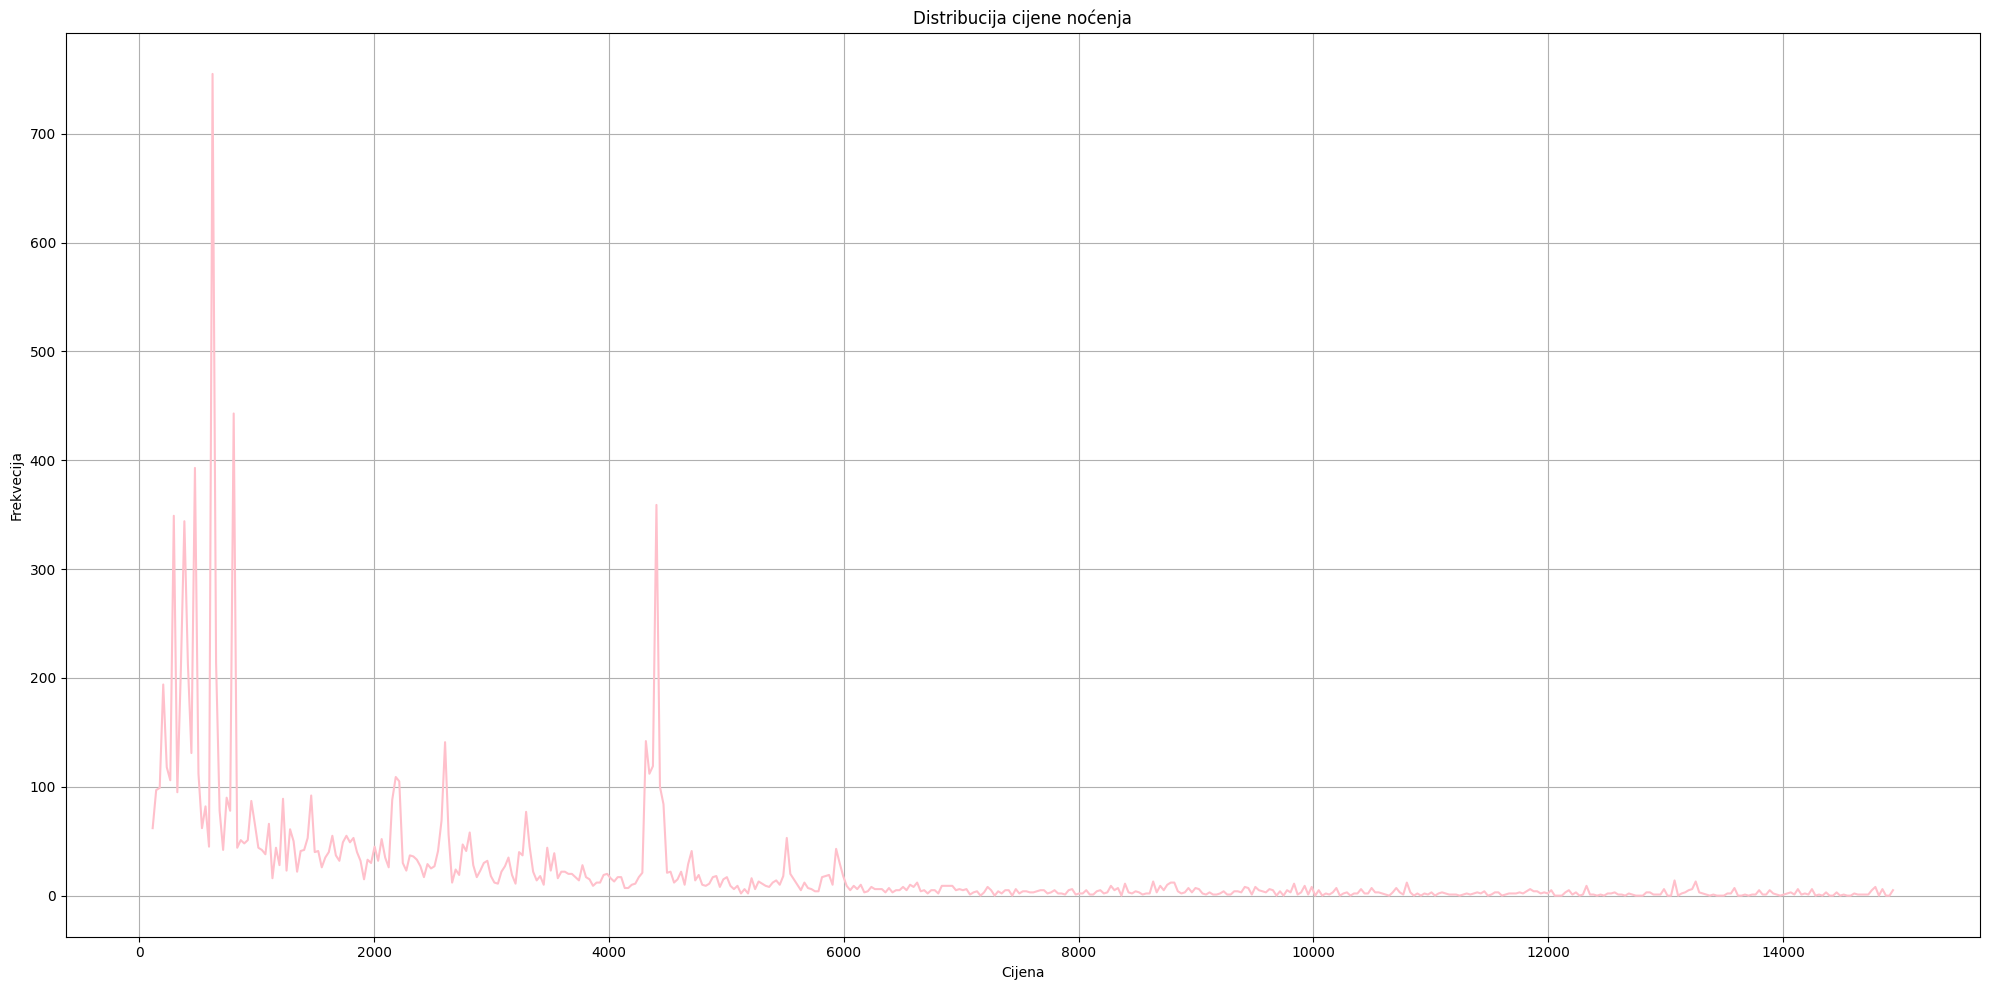

In [29]:
plt.figure(figsize = (20, 10))
plt.plot(price_counts_df["price"], price_counts_df["count"], color = "pink")
plt.title("Distribucija cijene noćenja")
plt.xlabel("Cijena")
plt.ylabel("Frekvecija")
plt.grid(True)
plt.tight_layout()
plt.show()

Iz grafičkog prikaza vidimo da su podatci nakon 6500 asimptotski gotovo 0 te ćemo pogledati i grafički prikaz bez tih podataka.

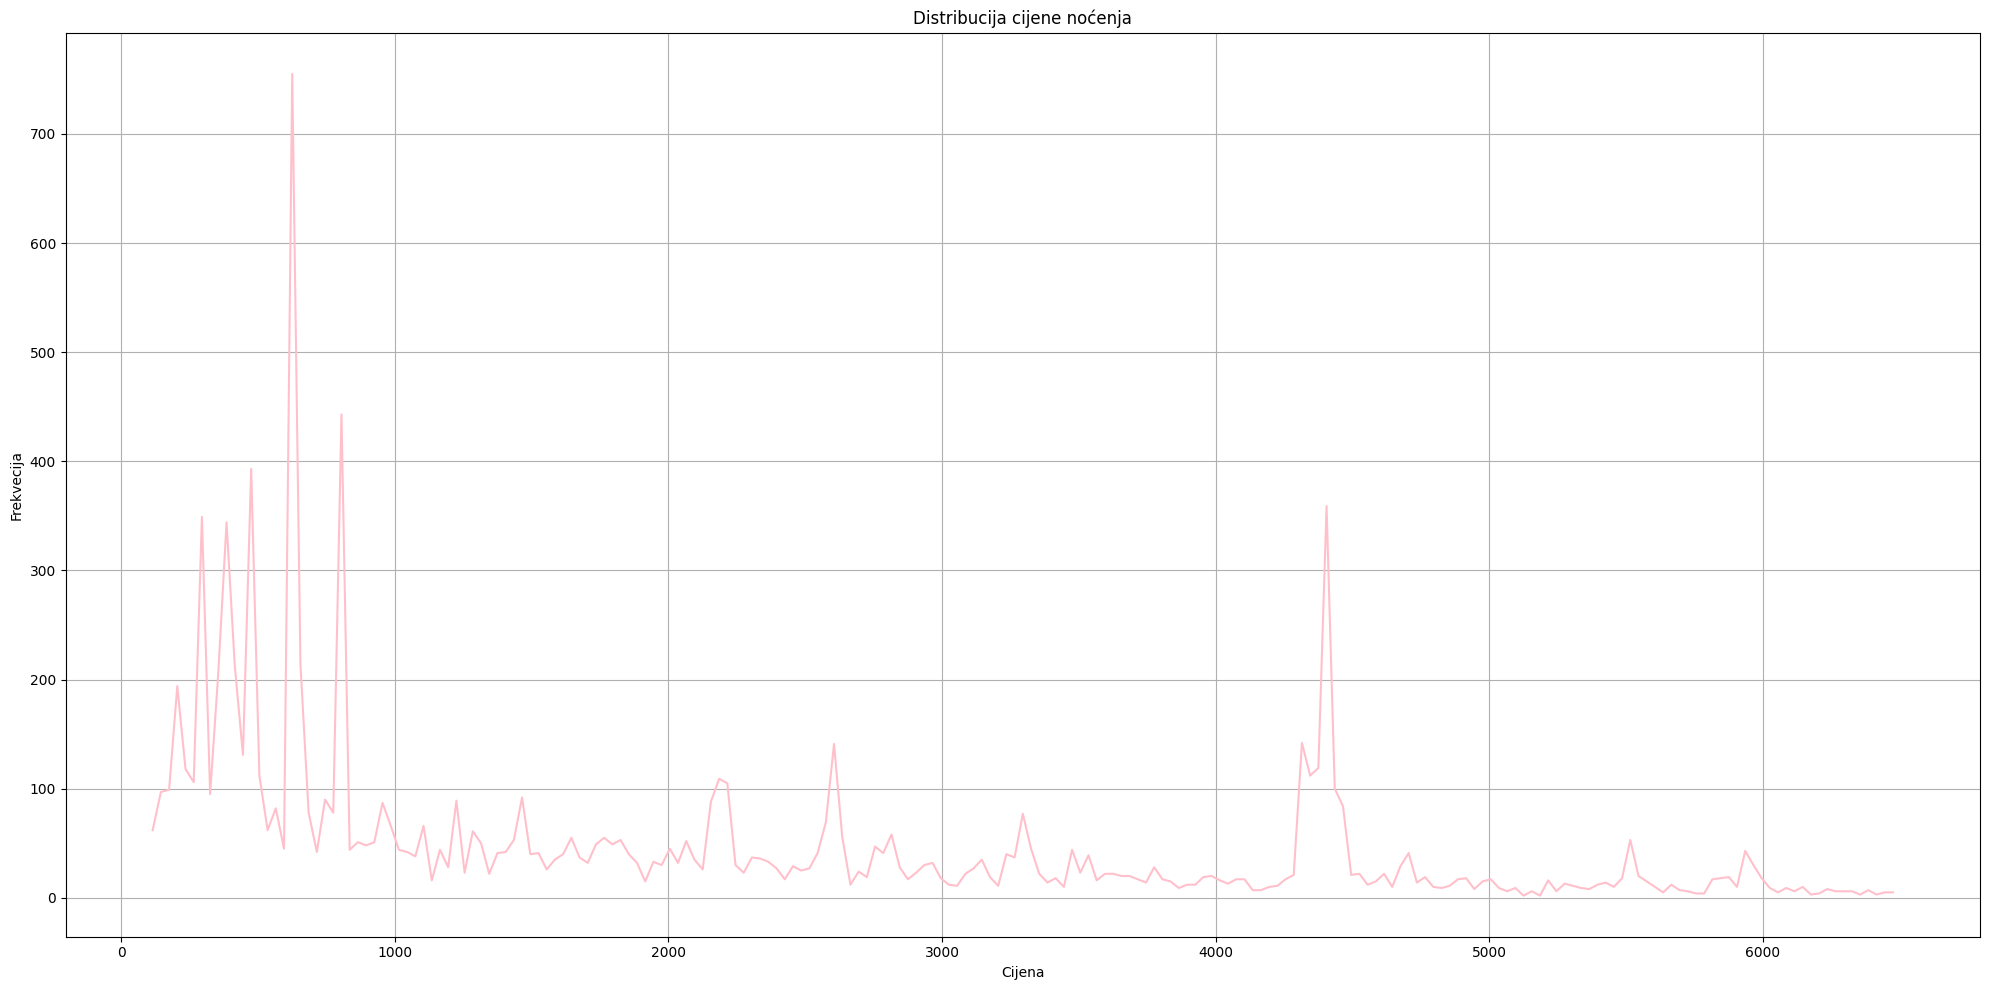

In [30]:
#kopiramo proces iznad
prices_df = prices_df[prices_df["nightly_price_per_guest"] < 6500]
price_bins = np.arange(100, prices_df["nightly_price_per_guest"].max(), 30)
price_ranges = pd.cut(prices_df["nightly_price_per_guest"], bins = price_bins)
price_counts = price_ranges.value_counts().sort_index()
price_midpoints = price_bins[:-1] + np.diff(price_bins) / 2
price_counts_df = pd.DataFrame({"price": price_midpoints, "count": price_counts.values})
plt.figure(figsize=(20, 10))
plt.plot(price_counts_df["price"], price_counts_df["count"], color = "pink")
plt.title("Distribucija cijene noćenja")
plt.xlabel("Cijena")
plt.ylabel("Frekvecija")
plt.grid(True)
plt.tight_layout()
plt.show()

Ovaj graf je puno prihvatljiviji i odlučujemo izbaciti podatke koji imaju "nightly_price_per_guest" preko 6500 jer ta cijena uključuje samo noćenja bez dodatnih troškova i podatci s cijenom preko 6500 po gostu nisu realni za hotel u Rijeci 2008./2009. godine pogotovo razmatrajući veliku krizu točno u tom periodu.

In [31]:
prices_df = prices_df[prices_df["nightly_price_per_guest"] < 6500]
path = Path.cwd().parent
filePath = str(path) + "/data_cleanup/second_dataset/"
name_csv = filePath + "train_data_price_corrected.csv"
name_parq = filePath + "train_data_price_corrected.parquet"
prices_df.to_csv(name_csv)
prices_df.to_parquet(name_parq)

Dalje tražimo najbolji mogući opis grafa distribucije cijene noćenja.

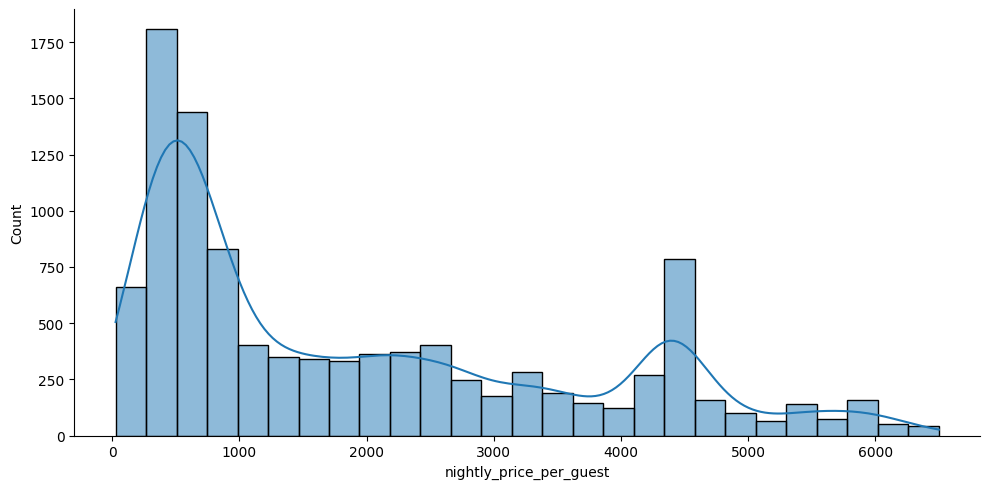

In [32]:
sns.displot(prices_df["nightly_price_per_guest"],kde = True,height=5, aspect=2)

In [33]:
shapiro(prices_df["nightly_price_per_guest"])

ShapiroResult(statistic=0.8641840855067243, pvalue=4.3294279729382825e-69)

Odbacujemo hipotezu da je "nightly_price_per_guest" normalno distribuirana slučajna varijabla.

### Teoretski prikaz grafa normalne razdiobe slučajne varijable cijene noćenja

In [34]:
Q1 = prices_df["nightly_price_per_guest"].quantile(0.25)
Q3 = prices_df["nightly_price_per_guest"].quantile(0.75)

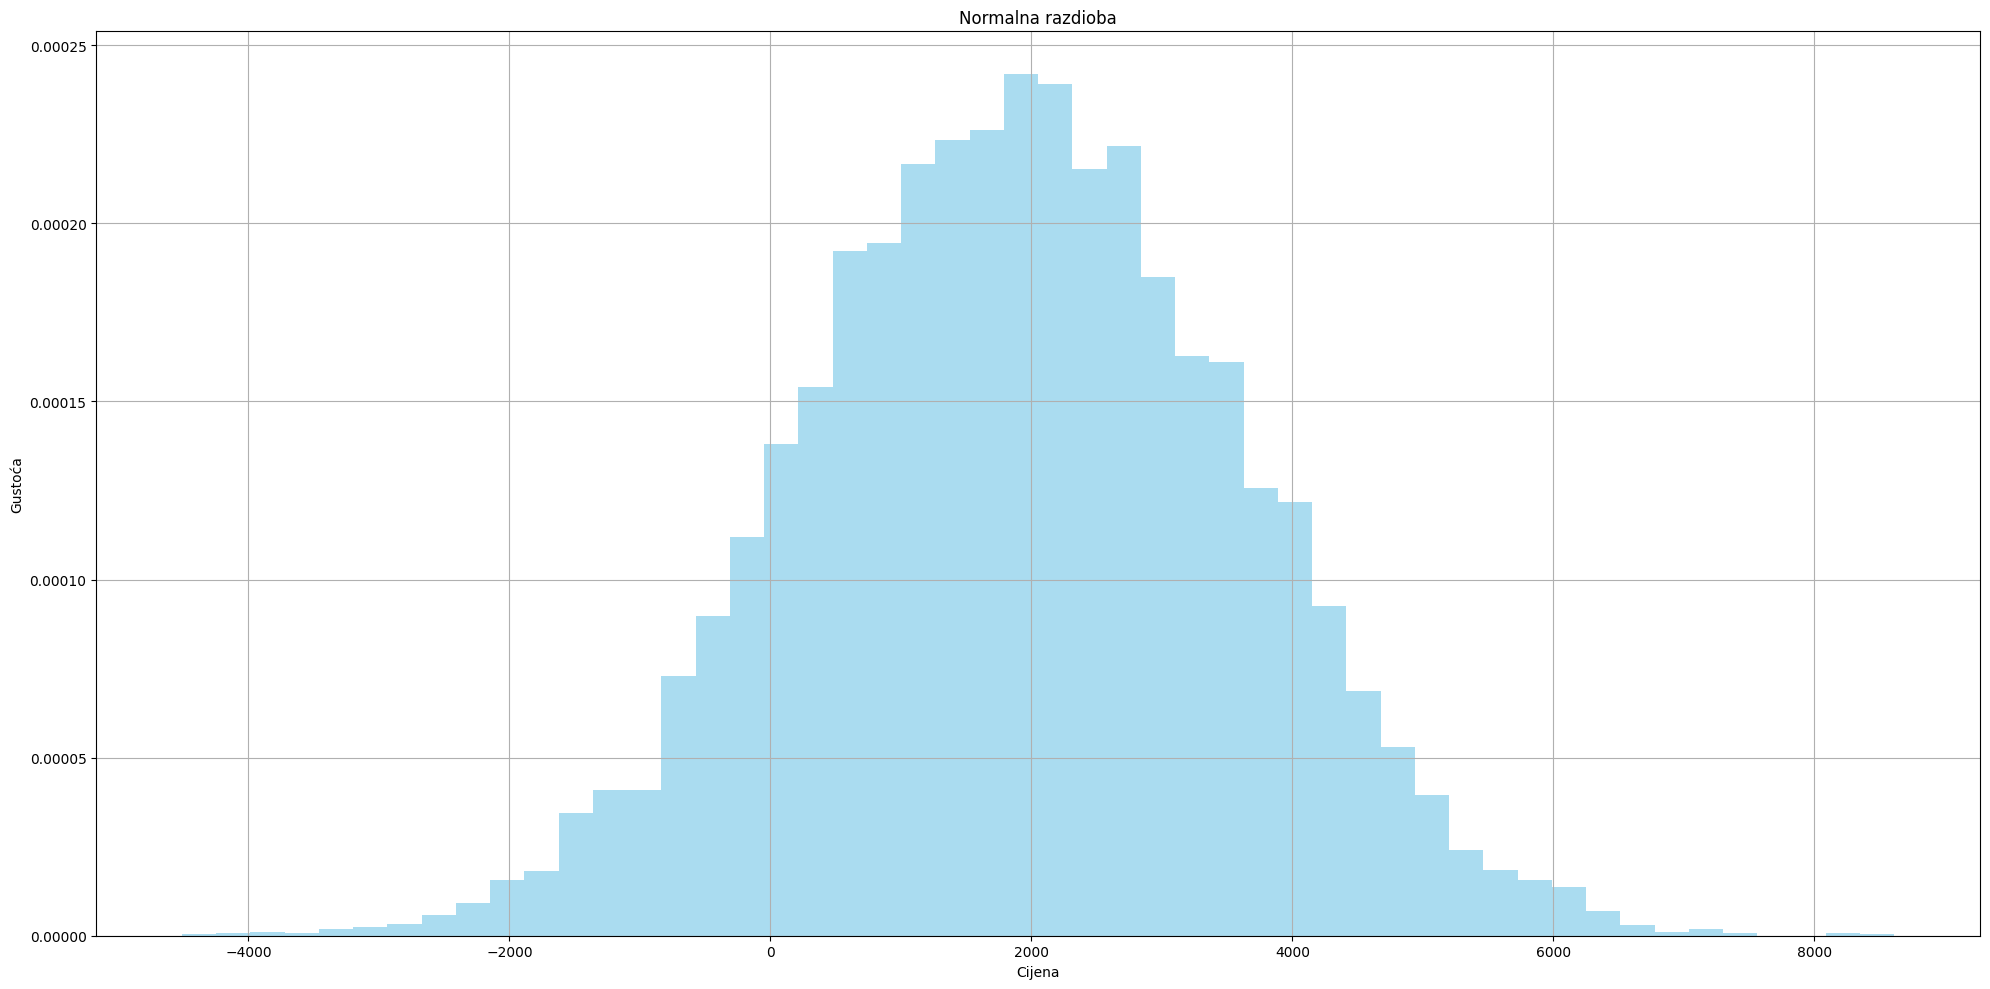

In [35]:
mean =  prices_df["nightly_price_per_guest"].mean()
std_dev = prices_df["nightly_price_per_guest"].std()
sample_size = len(prices_df)
sample_data = np.random.normal(loc = mean, scale = std_dev, size = sample_size)

plt.figure(figsize=(20, 10))
plt.hist(sample_data, bins=50, density=True, alpha=0.7, color='skyblue')
plt.title('Normalna razdioba')
plt.xlabel("Cijena")
plt.ylabel("Gustoća")
plt.grid(True)
plt.tight_layout()
plt.show()

### Distribucija cijene sobe

In [36]:
init_df["price_per_room"] = init_df["price"] / init_df["room_cnt"]
prices_df["guest_price_per_room"] = prices_df["nightly_price_per_guest"] / prices_df["room_cnt"]

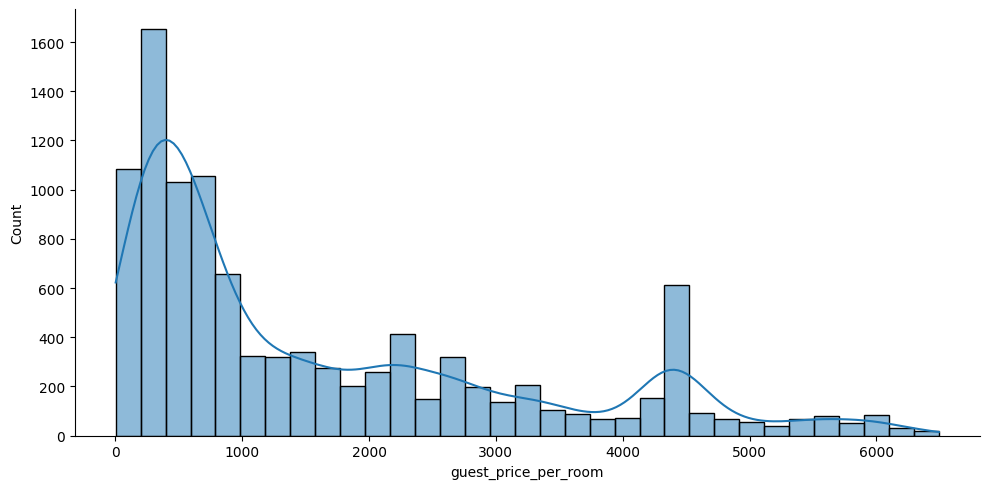

In [37]:
sns.displot(prices_df["guest_price_per_room"],kde = True,height=5, aspect=2)
plt.show()

In [38]:
kstest(prices_df["guest_price_per_room"], 'norm')

KstestResult(statistic=0.9995472840616288, pvalue=0.0, statistic_location=3.5959658119658116, statistic_sign=-1)

Također odbacujemo da je cijena po sobi normalno distribuirana.

### Pregled distribucija ostalih parametara

array([[<Axes: title={'center': 'reservation_id'}>,
        <Axes: title={'center': 'stay_date'}>,
        <Axes: title={'center': 'guest_id'}>,
        <Axes: title={'center': 'reservation_date'}>,
        <Axes: title={'center': 'date_from'}>],
       [<Axes: title={'center': 'date_to'}>,
        <Axes: title={'center': 'room_cnt'}>,
        <Axes: title={'center': 'adult_cnt'}>,
        <Axes: title={'center': 'children_cnt'}>,
        <Axes: title={'center': 'price'}>],
       [<Axes: title={'center': 'price_tax'}>,
        <Axes: title={'center': 'total_price_tax'}>,
        <Axes: title={'center': 'total_price'}>,
        <Axes: title={'center': 'food_price'}>,
        <Axes: title={'center': 'food_price_tax'}>],
       [<Axes: title={'center': 'other_price'}>,
        <Axes: title={'center': 'other_price_tax'}>,
        <Axes: title={'center': 'room_category_id'}>,
        <Axes: title={'center': 'sales_channel_id'}>,
        <Axes: title={'center': 'stay_nights'}>],
       [<Ax

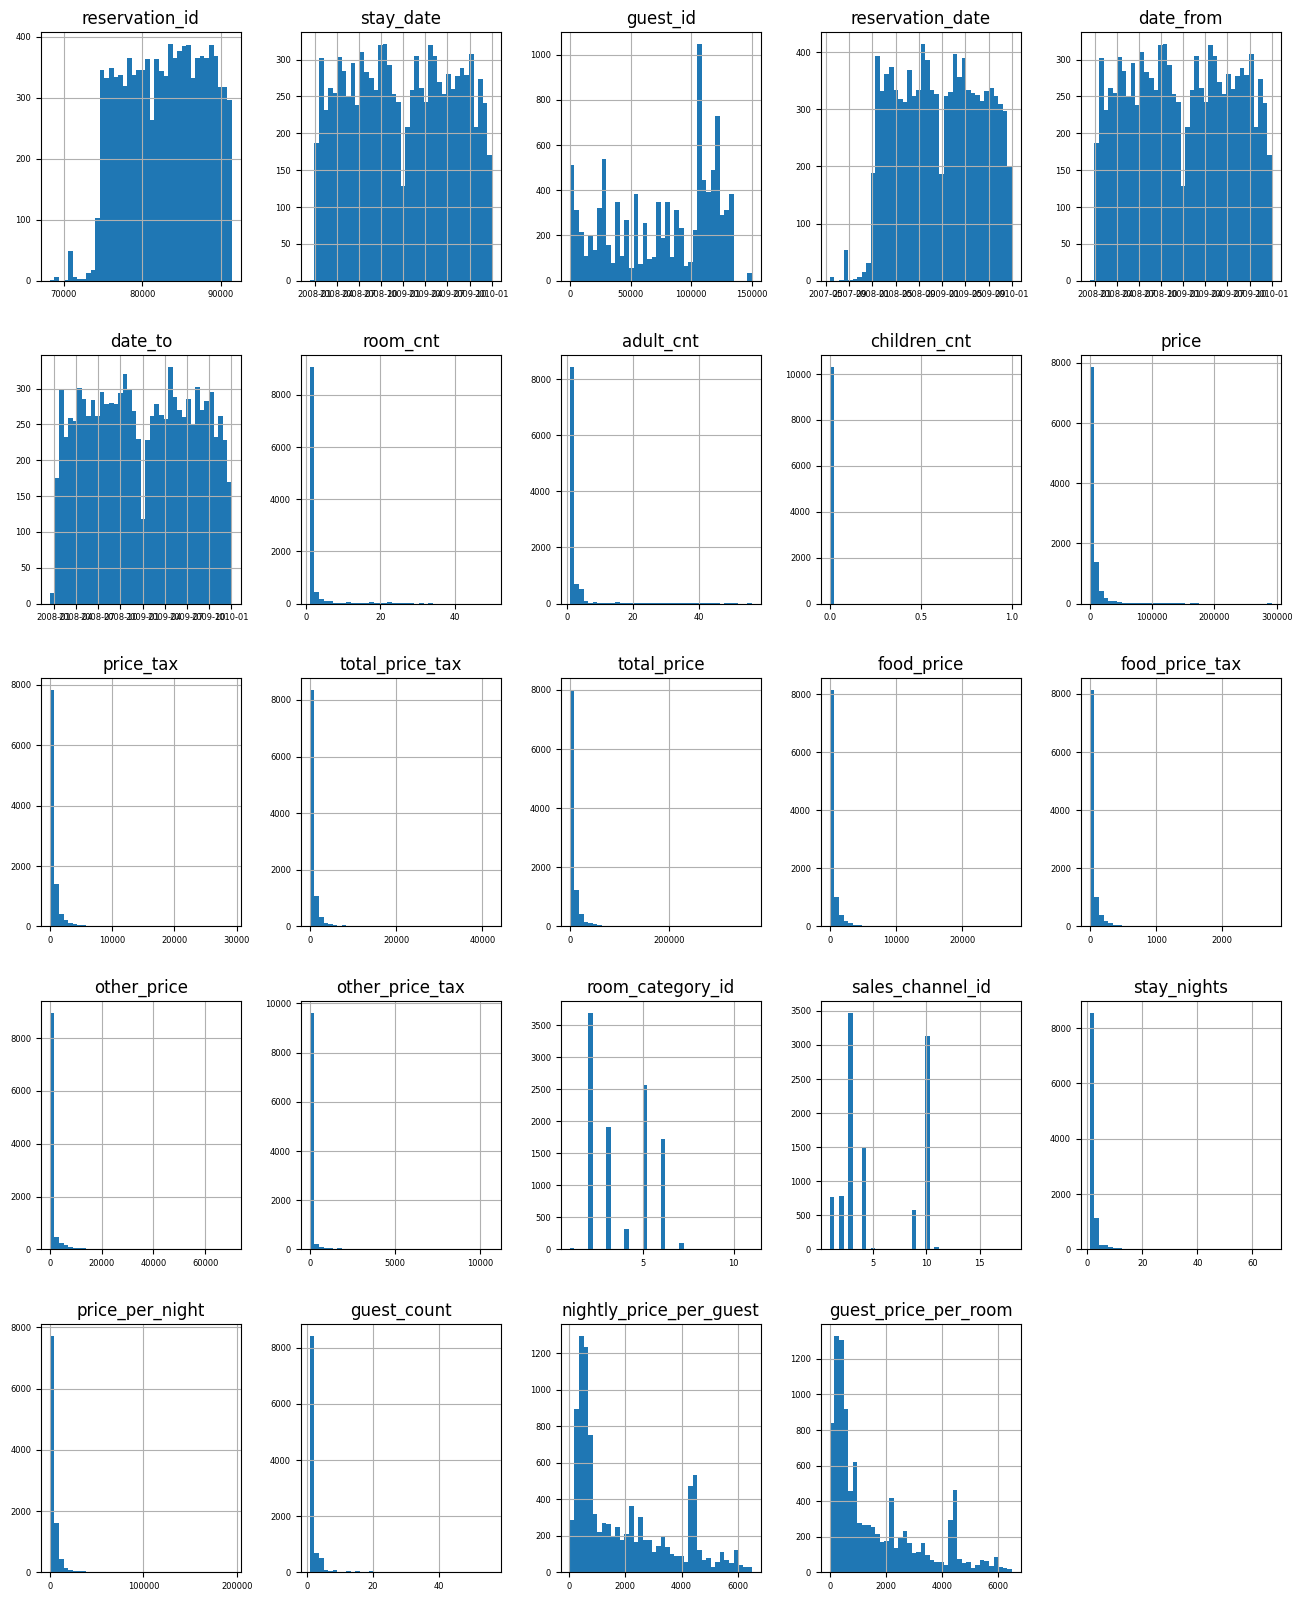

In [39]:
prices_df.hist(figsize=(16, 20), bins=40, xlabelsize=6, ylabelsize=6)

### Funkcija za brisanje odstupanja

In [40]:
def remove_outliers(df, column):
    lower_bound = df[column].quantile(0.05)
    upper_bound = df[column].quantile(0.95)
    
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return filtered_df

### Distribucija popunjenosti soba

Promatramo popunjenost soba po danima u tjednu.

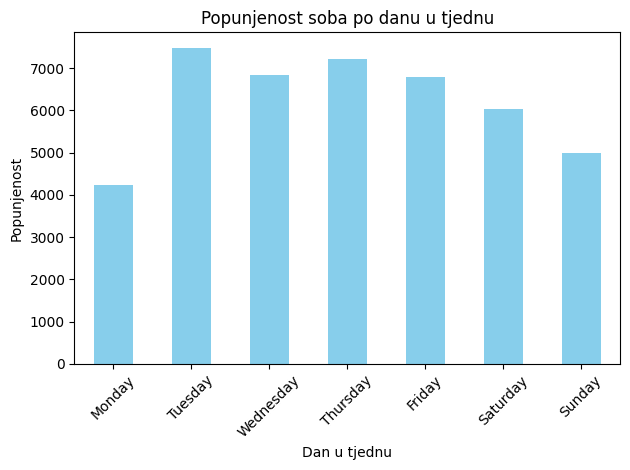

In [41]:
room_occupancy["day_of_week"] = room_occupancy.index.day_name()
occupancy_by_day = room_occupancy.groupby("day_of_week")["room_cnt"].sum()
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
occupancy_by_day.index = pd.Categorical(occupancy_by_day.index, categories = day_order, ordered = True)
occupancy_by_day = occupancy_by_day.sort_index()
occupancy_by_day.plot(kind = "bar", color = "skyblue")
plt.title("Popunjenost soba po danu u tjednu")
plt.xlabel("Dan u tjednu")
plt.ylabel("Popunjenost")
plt.xticks(rotation = 45) 
plt.tight_layout()
plt.show()


Ovdje vidimo neočekivano veliku popunjenost soba u sred radnom tjedna čak i veću nego tijekom vikenda.

### Razlika u broju zauzetih soba sa podatkom godinu dana unazad

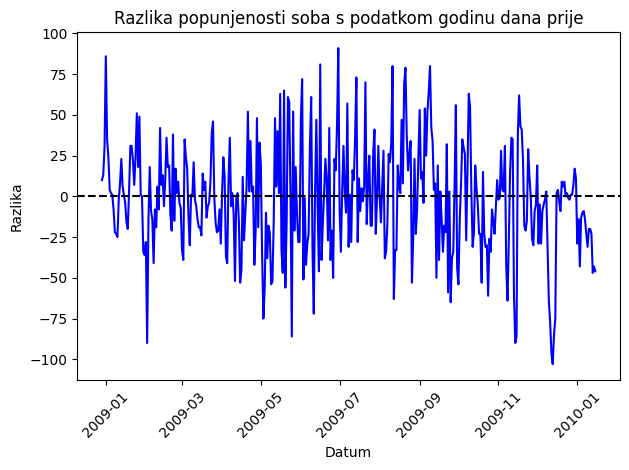

In [42]:
room_occupancy["room_cnt_difference"] = room_occupancy["room_cnt"] - room_occupancy["room_cnt"].shift(365)

plt.plot(room_occupancy.index, room_occupancy["room_cnt_difference"], color="blue")
plt.axhline(y=0, color="black", linestyle="--")  # Add dashed line at y=0
plt.title("Razlika popunjenosti soba s podatkom godinu dana prije")
plt.xlabel("Datum")
plt.ylabel("Razlika")
plt.xticks(rotation = 45) 
plt.tight_layout()
plt.show()

### Korelacije

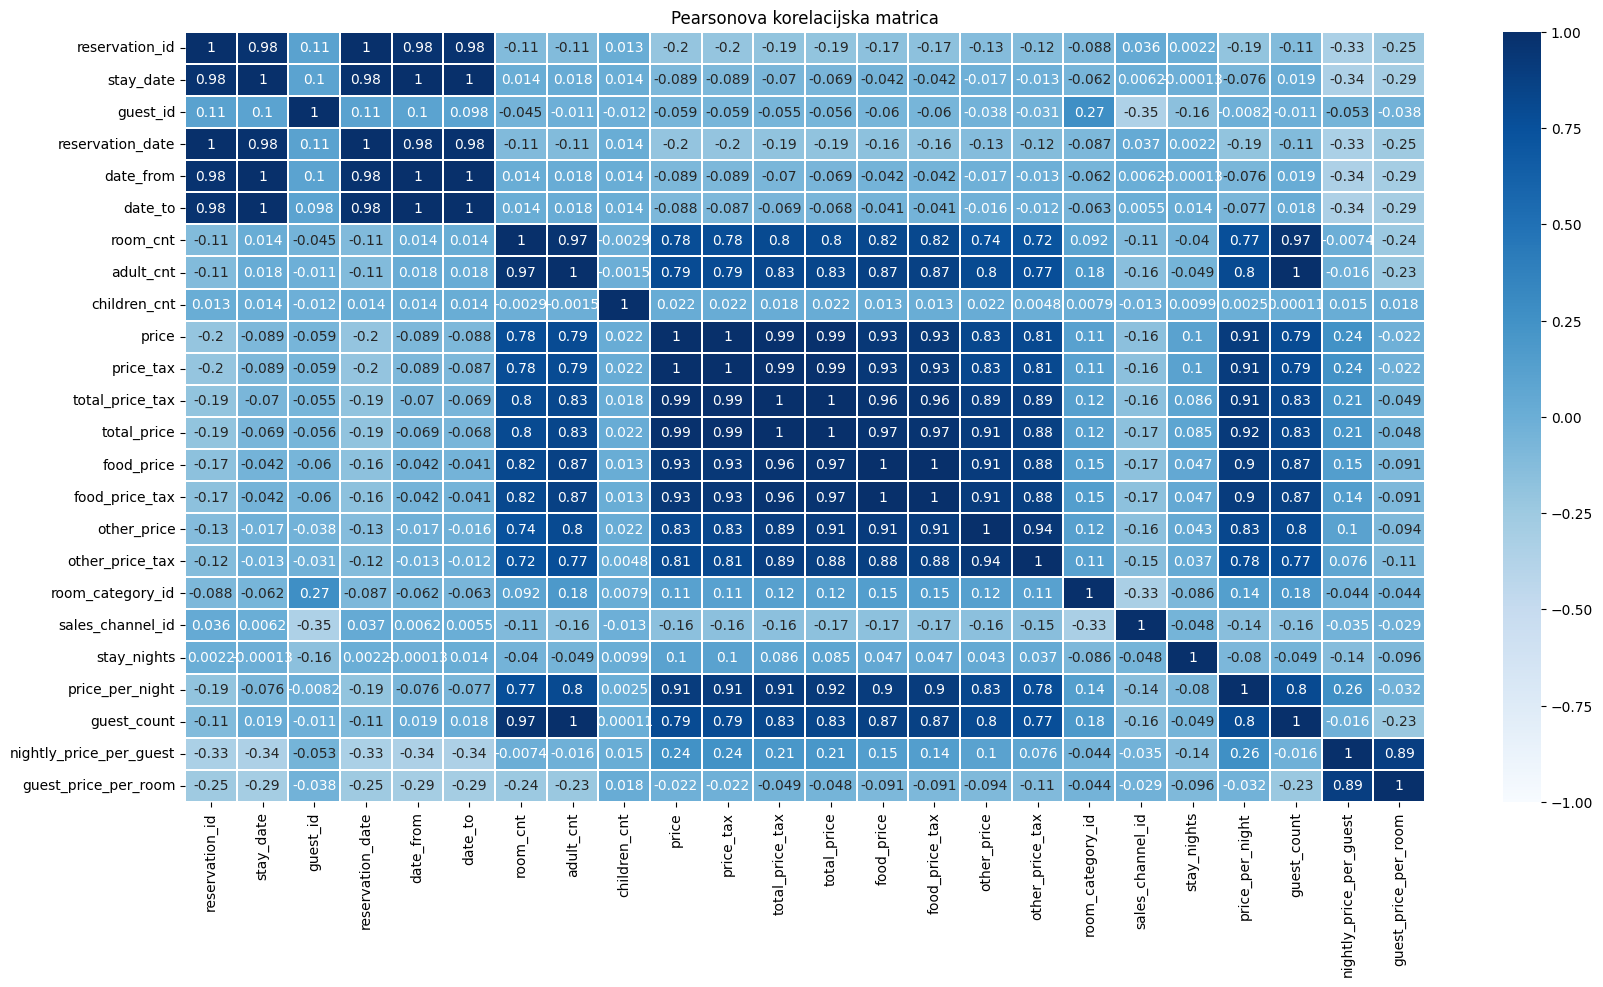

In [43]:
plt.figure(figsize=(20,10))
numeric_data = prices_df.select_dtypes(include = ["int", "float", "datetime"])
corr_matrix = numeric_data.corr()
sns.heatmap(corr_matrix, annot = True, cmap = "Blues", linewidths=0.2, fmt=".2g", vmin=-1, vmax=1)
plt.title("Pearsonova korelacijska matrica")
plt.show()

Iz korelacijske matrice vidimo da nam datum dolaska/odlaska nema gotovo nikakvu korelaciju s drugim podatcima. Isto tako i broj zauzetih soba osim korelacije sa cijenom koja je očekivana.